In [1]:
import pandas as pd
import yfinance as yf
from datetime import date, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Définir la période pour récupérer les données
end_date = date.today().strftime("%Y-%m-%d")
start_date = (date.today() - timedelta(days=365)).strftime("%Y-%m-%d")

# Liste des tickers d'actions
tickers = ['RELIANCE.NS', 'TCS.NS', 'INFY.NS', 'HDFCBANK.NS']

# Télécharger les données boursières
data = yf.download(tickers, start=start_date, end=end_date, progress=False)

# Réinitialiser l'index pour inclure la date
data = data.reset_index()

# Aplatir les colonnes MultiIndex
data.columns = ['_'.join(col).strip() if col[1] else col[0] for col in data.columns]
print(data.columns)

# Transformer le DataFrame en un format long où chaque ligne est une combinaison unique de Date, Ticker, et attributes
data_melted = data.melt(id_vars=['Date'], var_name='Attribute_Ticker', value_name='value')

# diviser la colonne 'Attribute_Ticker' à 'Attribute' et 'Ticker'
data_melted[['Attribute', 'Ticker']] = data_melted['Attribute_Ticker'].str.split('_', expand=True)

# Faire un pivot du DataFrame transformé pour que les attributs (Open, High, Low, etc.) deviennent des colonnes
data_pivoted = data_melted.pivot_table(index=['Date', 'Ticker'], columns='Attribute', values='value', aggfunc='first')

# Réinitialiser l'index pour transformer le multi-index en colonnes
stock_data = data_pivoted.reset_index()

print(stock_data.head())

Index(['Date', 'Adj Close_HDFCBANK.NS', 'Adj Close_INFY.NS',
       'Adj Close_RELIANCE.NS', 'Adj Close_TCS.NS', 'Close_HDFCBANK.NS',
       'Close_INFY.NS', 'Close_RELIANCE.NS', 'Close_TCS.NS',
       'High_HDFCBANK.NS', 'High_INFY.NS', 'High_RELIANCE.NS', 'High_TCS.NS',
       'Low_HDFCBANK.NS', 'Low_INFY.NS', 'Low_RELIANCE.NS', 'Low_TCS.NS',
       'Open_HDFCBANK.NS', 'Open_INFY.NS', 'Open_RELIANCE.NS', 'Open_TCS.NS',
       'Volume_HDFCBANK.NS', 'Volume_INFY.NS', 'Volume_RELIANCE.NS',
       'Volume_TCS.NS'],
      dtype='object')
Attribute                      Date       Ticker    Adj Close        Close  \
0         2023-09-07 00:00:00+00:00  HDFCBANK.NS  1589.149414  1610.849976   
1         2023-09-07 00:00:00+00:00      INFY.NS  1427.184082  1466.199951   
2         2023-09-07 00:00:00+00:00  RELIANCE.NS  2423.773682  2432.000000   
3         2023-09-07 00:00:00+00:00       TCS.NS  3397.792236  3455.250000   
4         2023-09-08 00:00:00+00:00  HDFCBANK.NS  1601.530396  1623.4

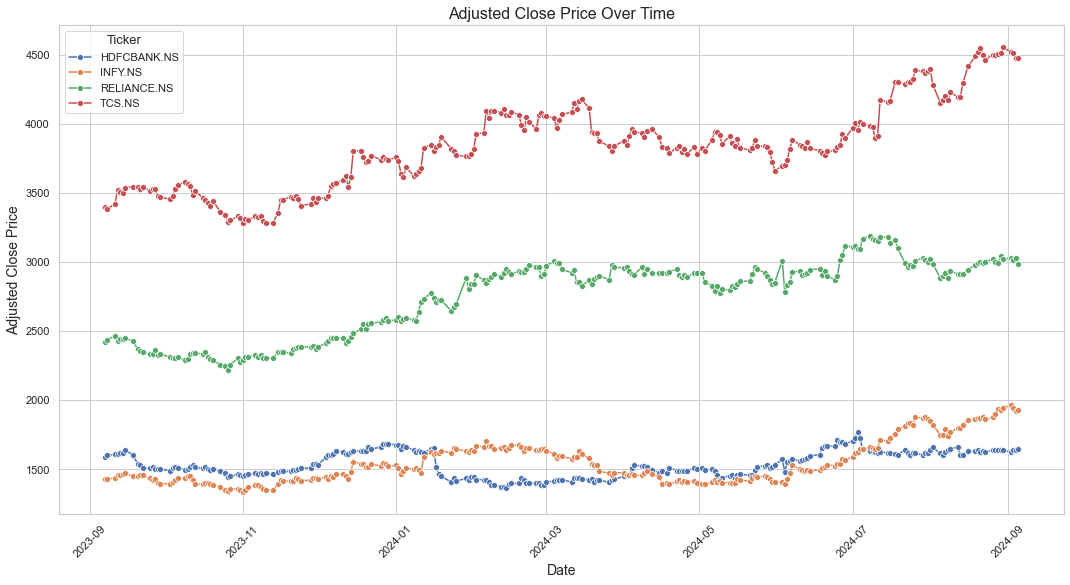

In [3]:
# S'assurer que la colonne 'Date' est sur le format datetime
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

stock_data = stock_data[['Date', 'Ticker', 'Adj Close']].dropna()

# Plot
plt.figure(figsize=(18, 9))
sns.set(style='whitegrid')

sns.lineplot(data=stock_data, x='Date', y='Adj Close', hue='Ticker', marker='o')

plt.title('Adjusted Close Price Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Adjusted Close Price', fontsize=14)
plt.legend(title='Ticker', title_fontsize='13', fontsize='11')
plt.grid(True)
plt.xticks(rotation=45)

plt.show()

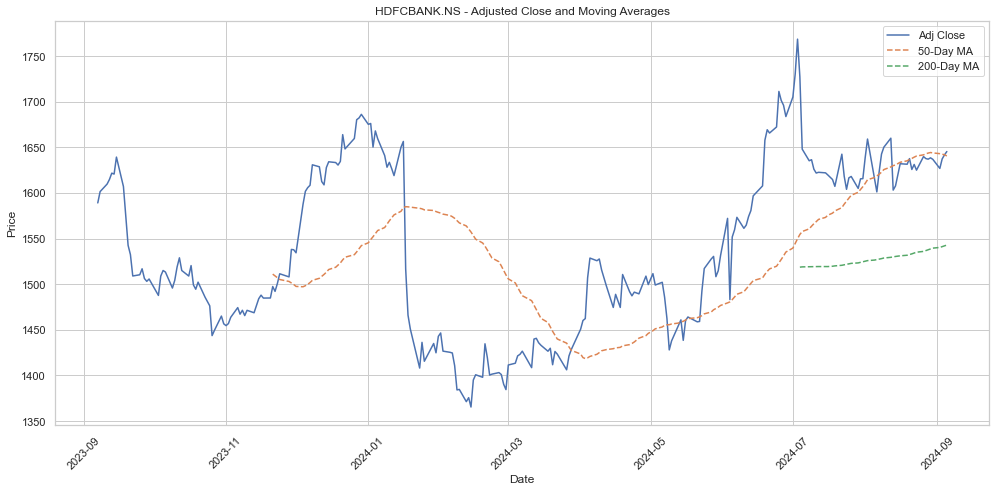

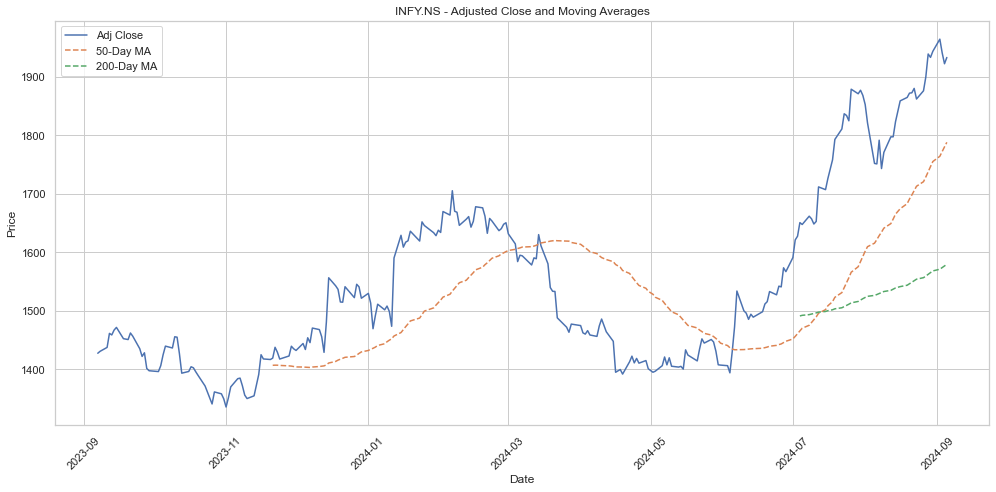

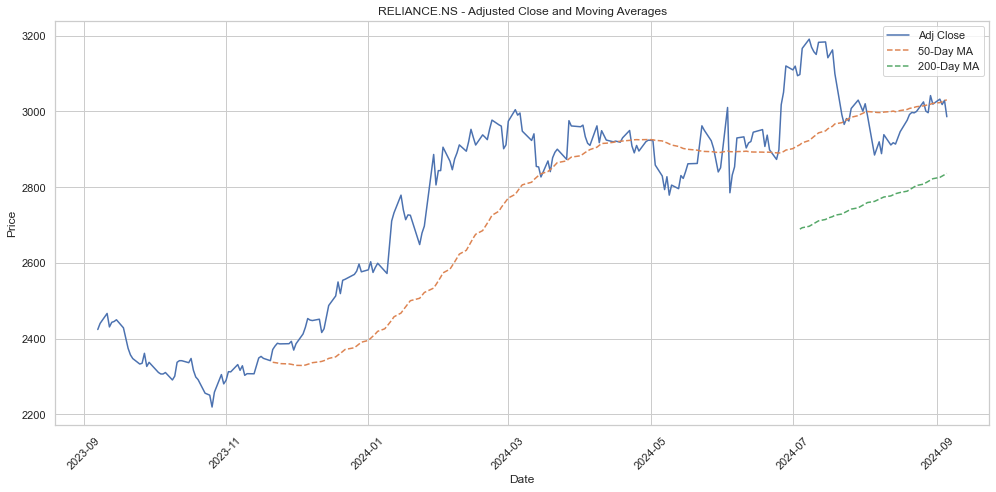

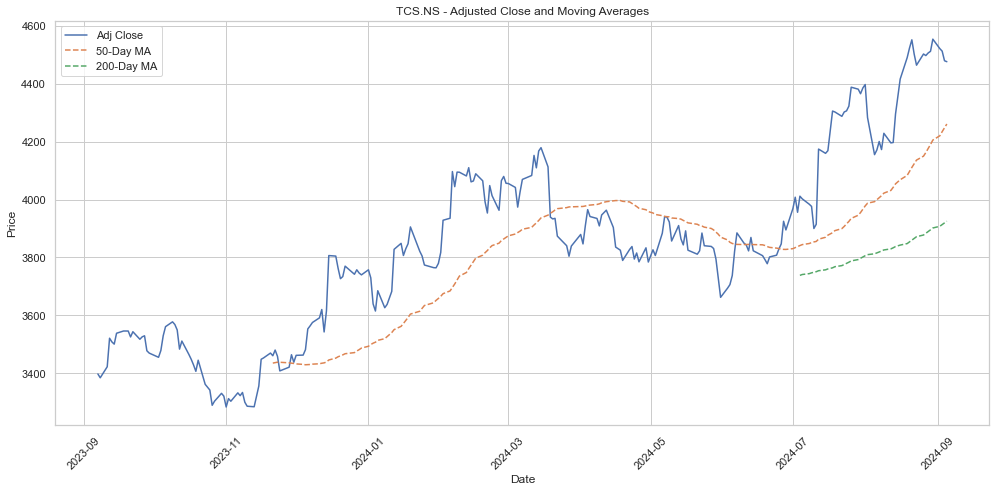

In [4]:
# moving averages (moyennes mobile) et graphiques par ticker
short_window = 50
long_window = 200

# S'assurer que 'Date' est défini comme index
stock_data.set_index('Date', inplace=True)

# Obtenir des 'tickers' unique
unique_tickers = stock_data['Ticker'].unique()

for ticker in unique_tickers:
    ticker_data = stock_data[stock_data['Ticker'] == ticker].copy()
    
    # Calculer moving averages
    ticker_data['50_MA'] = ticker_data['Adj Close'].rolling(window=short_window).mean()
    ticker_data['200_MA'] = ticker_data['Adj Close'].rolling(window=long_window).mean()

    # Plot Adjusted Close et Moving Averages
    plt.figure(figsize=(14, 7))
    plt.plot(ticker_data.index, ticker_data['Adj Close'], label='Adj Close')
    plt.plot(ticker_data.index, ticker_data['50_MA'], label='50-Day MA', linestyle='--')
    plt.plot(ticker_data.index, ticker_data['200_MA'], label='200-Day MA', linestyle='--')
    plt.title(f'{ticker} - Adjusted Close and Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

   

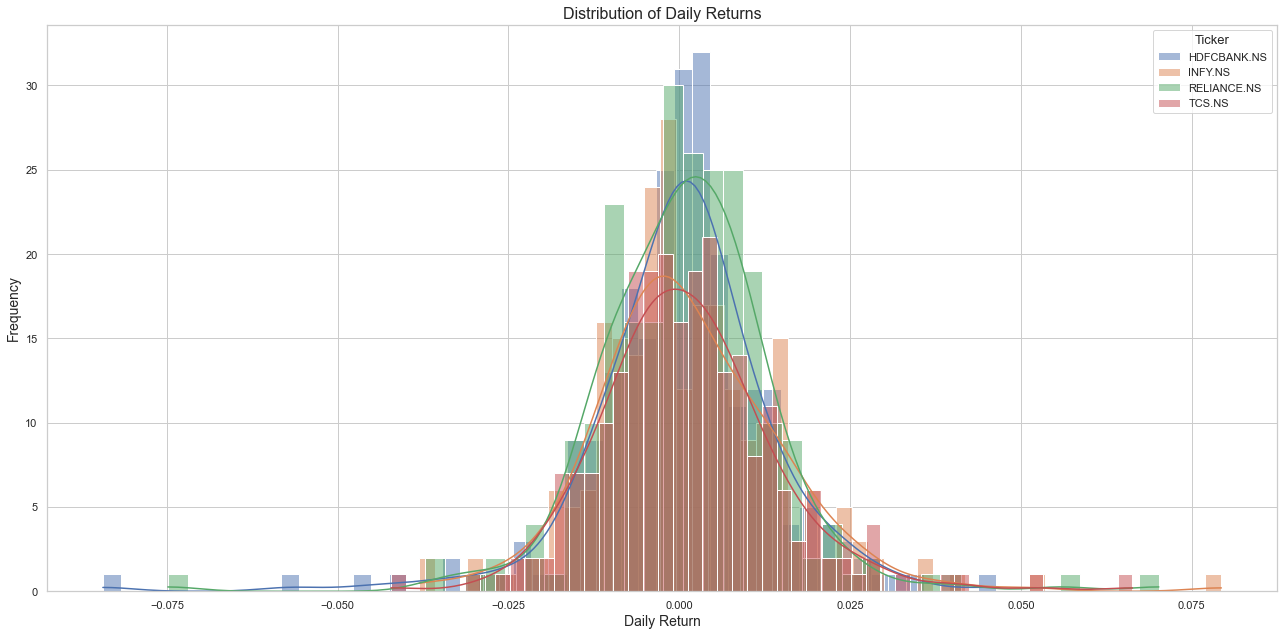

In [10]:
stock_data['Daily Return'] = stock_data.groupby('Ticker')['Adj Close'].pct_change()

plt.figure(figsize=(18, 9))
sns.set(style='whitegrid')

for ticker in unique_tickers:
    ticker_data = stock_data[stock_data['Ticker'] == ticker]
    sns.histplot(ticker_data['Daily Return'].dropna(), bins=50, kde=True, label=ticker, alpha=0.5)

plt.title('Distribution of Daily Returns', fontsize=16)
plt.xlabel('Daily Return', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(title='Ticker', title_fontsize='13', fontsize='11')
plt.grid(True)
plt.tight_layout()
plt.show()

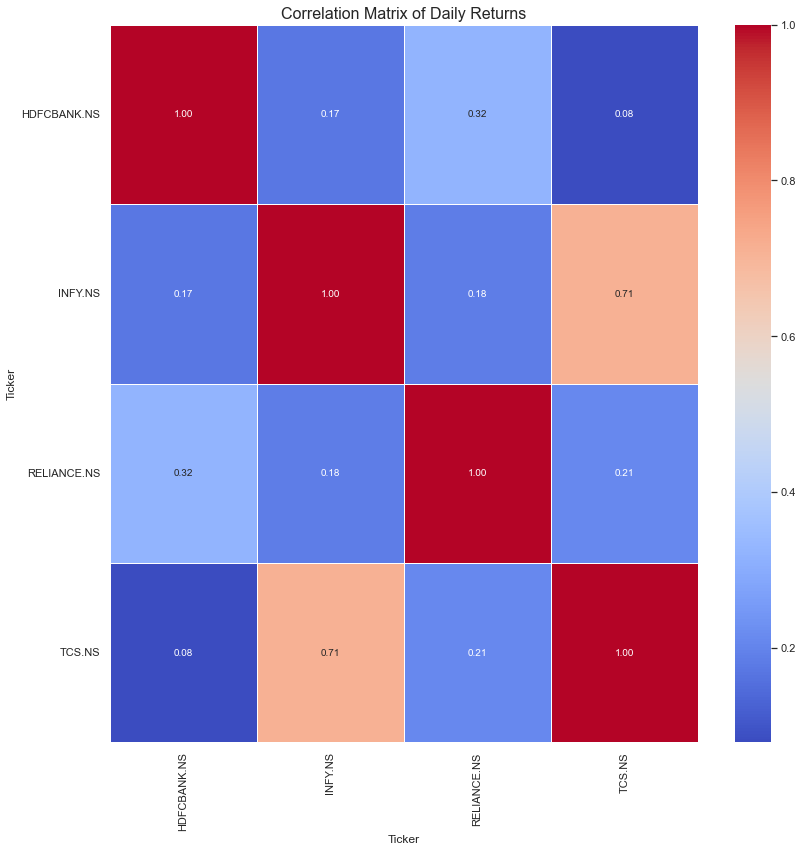

In [12]:
daily_returns = stock_data.pivot_table(index='Date', columns='Ticker', values='Daily Return')
correlation_matrix = daily_returns.corr()

plt.figure(figsize=(12, 12))
sns.set(style='whitegrid')

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5, fmt='.2f', annot_kws={"size": 10})
plt.title('Correlation Matrix of Daily Returns', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [13]:
import numpy as np

expected_returns = daily_returns.mean() * 252  # annualiser le rendement
volatility = daily_returns.std() * np.sqrt(252)  # annualiser la volatilité

stock_stats = pd.DataFrame({
    'Expected Return': expected_returns,
    'Volatility': volatility
})

stock_stats

,Expected Return,Volatility
Ticker,,
HDFCBANK.NS,0.059905,0.216586
INFY.NS,0.340423,0.221683
RELIANCE.NS,0.240003,0.213567
TCS.NS,0.308416,0.207536


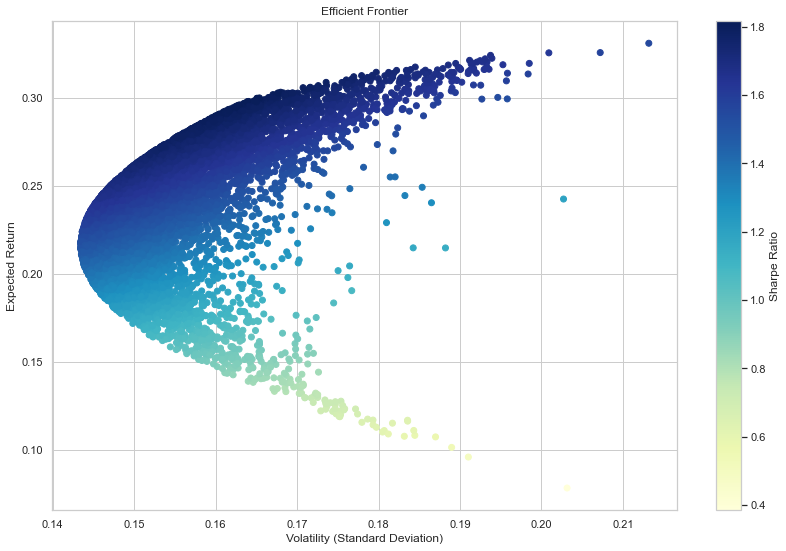

In [15]:
# fonction qui calcule la performance du portfolio
def portfolio_performance(weights, returns, cov_matrix):
    portfolio_return = np.dot(weights, returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_volatility

# nombre des portfolia à simuler
num_portfolios = 10000

results = np.zeros((3, num_portfolios))

# matrice de covariance annuelle
cov_matrix = daily_returns.cov() * 252

np.random.seed(42)

for i in range(num_portfolios):
    weights = np.random.random(len(unique_tickers))
    weights /= np.sum(weights)

    portfolio_return, portfolio_volatility = portfolio_performance(weights, expected_returns, cov_matrix)

    results[0,i] = portfolio_return
    results[1,i] = portfolio_volatility
    results[2,i] = portfolio_return / portfolio_volatility  # Sharpe Ratio

plt.figure(figsize=(14, 9))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='YlGnBu', marker='o')
plt.title('Efficient Frontier')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
plt.grid(True)
plt.show()

In [16]:
max_sharpe_idx = np.argmax(results[2])
max_sharpe_return = results[0, max_sharpe_idx]
max_sharpe_volatility = results[1, max_sharpe_idx]
max_sharpe_ratio = results[2, max_sharpe_idx]

max_sharpe_return, max_sharpe_volatility, max_sharpe_ratio

(np.float64(0.29570958028347794),
 np.float64(0.16277207777971664),
 np.float64(1.8167095015133297))

In [17]:
max_sharpe_weights = np.zeros(len(unique_tickers))

for i in range(num_portfolios):
    weights = np.random.random(len(unique_tickers))
    weights /= np.sum(weights)

    portfolio_return, portfolio_volatility = portfolio_performance(weights, expected_returns, cov_matrix)

    if results[2, i] == max_sharpe_ratio:
        max_sharpe_weights = weights
        break

portfolio_weights_df = pd.DataFrame({
    'Ticker': unique_tickers,
    'Weight': max_sharpe_weights
})

portfolio_weights_df

,Ticker,Weight
0,HDFCBANK.NS,0.494044
1,INFY.NS,0.106153
2,RELIANCE.NS,0.399797
3,TCS.NS,0.000006
